# Importation des librairies

In [41]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from munkres import Munkres
from model import CNNModel
import seaborn as sns
import torch.nn as nn
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import pickle
import torch
import tqdm
import ray

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Définition du modèle

In [42]:
MATRIX_SIZE = 12

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(
    state_size=MATRIX_SIZE**2,
    input_size=2,
    num_hidden=64
).to(device)

## Fonction pour augmenter la taille de la matrice

In [43]:
def augmented_matrix(matrix: np.ndarray, new_size: int, g1: nx.Graph, g2: nx.Graph) -> np.ndarray:
    if matrix.shape[0] > new_size or matrix.shape[1] > new_size:
        raise ValueError("New size is smaller than the original matrix")
    n = len(g1.nodes)
    m = len(g2.nodes)
    new_matrix = np.zeros((new_size, new_size))
    new_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    for i in range(new_size):
        for j in range(new_size):
            if i < n and j >= matrix.shape[0]:
                to_replace = matrix[i, -1]
                new_matrix[i, j] = to_replace
            elif i >= matrix.shape[1] and j < m:
                to_replace = matrix[-1, j]
                new_matrix[i, j] = to_replace

    return new_matrix


## Chargement des données

Taille du dataset : 99681


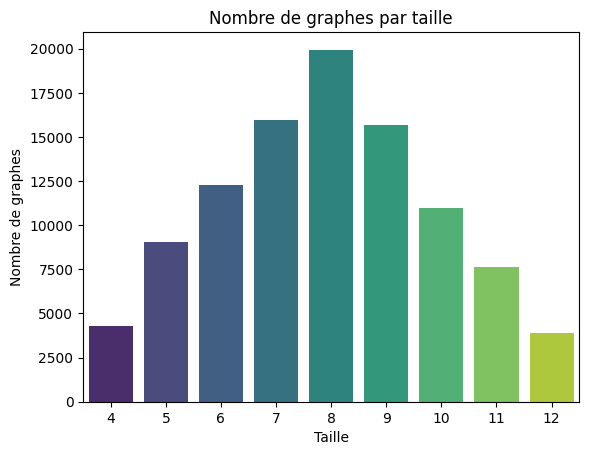

In [51]:
dataset_name = "447_graphs.pkl"

with open(f"processed/{dataset_name}", "rb") as file:
    data = pickle.load(file)

print(f"Taille du dataset : {len(data)}")

matrix = data.loc[1, "cost_matrix"]
g1 = data.loc[1, "g1"]
g2 = data.loc[1, "g2"]

sizes = {}
for i in range(len(data)):
    size = data.loc[i, "cost_matrix"].shape[0]
    if size not in sizes:
        sizes[size] = 1
    else:
        sizes[size] += 1

fig, ax = plt.subplots()
sns.set_style()
sns.barplot(x=np.array(list(sizes.keys())), y=np.array(list(sizes.values())), ax=ax, palette="viridis")
ax.set_title("Nombre de graphes par taille")
ax.set_xlabel("Taille")
ax.set_ylabel("Nombre de graphes")
plt.show()


## Génération des données pour le modèle à partir de la base de données

In [52]:
def process_matrix(matrix: np.ndarray, size: int) -> np.ndarray:
    """Process the matrix to be used as input for the model."""
    matrix = matrix.astype(np.float32)
    for i in range(size):
        total_value = matrix[i].sum()
        probs = [abs((value - total_value) ** 2) for value in matrix[i]]
        normalized_probs = [prob / sum(probs) for prob in probs]
        matrix[i] = np.round(normalized_probs, 2)
    return matrix


def solve_matrix(matrix: np.ndarray) -> np.ndarray:
    """Solve the matrix with the Hungarian algorithm."""
    m = Munkres()
    indexes = m.compute(matrix.copy().tolist())
    solution = np.zeros(matrix.shape)
    for row, column in indexes:
        solution[row][column] = 1
    return solution


def get_solutions(matrix: np.ndarray, solution: np.ndarray, size: int) -> tuple[list[np.ndarray], list[float]]:
    """Get all sub-solutions of a solution."""
    valid_solutions = [solution]
    valid_solutions_sum = [round(np.multiply(matrix, solution).sum(), 2)]
    # Remove successively the last one by row
    for k in range(size - 1):
        line = size - k - 1
        indexes = np.argwhere(valid_solutions[-1][line] == 1).flatten()
        if len(indexes) > 0:
            new_solution = valid_solutions[-1].copy()
            new_solution[line][indexes[0]] = 0
            valid_solutions.append(new_solution)
            valid_solutions_sum.append(
                round(np.multiply(matrix, new_solution).sum(), 2))
    return valid_solutions, valid_solutions_sum


def get_random_solution(size: int) -> np.ndarray:
    """Get a random solution."""
    random_permutation = np.random.permutation(size)
    solution = np.zeros((size, size))
    for k in range(size):
        solution[k][random_permutation[k]] = 1
    return solution


def generate_datas(datas: pd.DataFrame, size: int) -> tuple[np.ndarray, np.ndarray]:
    """Return processed data for the model"""
    states = []
    values = []

    for i in tqdm.tqdm(range(len(datas))):
        # Create a random process matrix
        random_matrix = np.array(datas.loc[i, "cost_matrix"])
        if random_matrix.shape[0] != size:
            random_matrix = augmented_matrix(
                random_matrix, size, datas.loc[i, "g1"], datas.loc[i, "g2"]
            )

        # Solve the problem with the Hungarian algorithm
        valide_solution = solve_matrix(random_matrix)

        # Get all sub-solutions of the valid solution and add them to the dataset
        valid_solutions, _ = get_solutions(
            random_matrix, valide_solution, size
        )

        for valid_solution in valid_solutions:
            state = np.stack([random_matrix, valid_solution], axis=0)
            states.append(torch.tensor(state, dtype=torch.float32))
            values.append(1)

        # Create a random solution
        solution = get_random_solution(size)

        # Get all sub-solutions of the random solution and add them to the dataset
        random_solutions, _ = get_solutions(random_matrix, solution, size)

        for (random_solution, valid_solution) in zip(random_solutions, valid_solutions):
            state = np.stack([random_matrix, random_solution], axis=0)
            states.append(torch.tensor(state, dtype=torch.float32))
            values.append(1 if np.array_equal(
                random_solution, valid_solution) else 0)

    return np.stack(states, axis=0), np.array(values)

In [53]:
sizes = {}
for i in range(len(data)):
    size = data.loc[i, "cost_matrix"].shape[0]
    if size not in sizes:
        sizes[size] = 1
    else:
        sizes[size] += 1

sizes = list(sizes.keys())
sizes = [MATRIX_SIZE]

model_data = {
    size: generate_datas(data, size) for size in sizes
}

test_percentage = 0.1
test_size = int(test_percentage * len(model_data[MATRIX_SIZE][0]))
print(f"Taille du dataset : {len(model_data[MATRIX_SIZE][0])}")
print(f"Taille du dataset de test : {test_size}")

train_states = model_data[MATRIX_SIZE][0][:-test_size]
train_values = model_data[MATRIX_SIZE][1][:-test_size]

test_states = model_data[MATRIX_SIZE][0][-test_size:]
test_values = model_data[MATRIX_SIZE][1][-test_size:]

dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_states, dtype=torch.float32),
    torch.tensor(train_values, dtype=torch.float32)
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 99681/99681 [02:25<00:00, 683.31it/s]


Taille du dataset : 2392344
Taille du dataset de test : 239234


## Entrainement du modèle

In [54]:
# Create a loss function and an optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    running_loss = 0
    for states, values in dataloader:
        optimizer.zero_grad()
        states = states.to(device)
        outputs = model(states)
        values = values.unsqueeze(1)
        values = torch.cat([1 - values, values], dim=1)
        values = values.to(device)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % 1 == 0:
        print(
            f"-----Epoch {epoch + 1}, loss: {running_loss / len(dataloader) * 10:.2f}-----"
        )

        values = test_values.reshape(-1, 1)
        values = np.concatenate([1 - values, values], axis=1)
        values = torch.tensor(values, dtype=torch.float32).to(device)
        outputs = model(torch.tensor(
            test_states, dtype=torch.float32).to(device))
        loss = criterion(outputs, values)
        print(f"Test loss trained model: {loss.item() * 10:.2f}")

        untrained_model = CNNModel(
            state_size=MATRIX_SIZE**2,
            input_size=2,
            num_hidden=64
        ).to(device)
        outputs = untrained_model(torch.tensor(
            test_states, dtype=torch.float32).to(device))
        loss = criterion(outputs, values)
        print(f"Test loss untrained model: {loss.item() * 10:.2f}\n")

-----Epoch 1, loss: 0.16-----


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.21 GiB. GPU 0 has a total capacty of 12.00 GiB of which 0 bytes is free. Of the allocated memory 16.70 GiB is allocated by PyTorch, and 28.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Evaluation du modèle

Sample size: [19936, 19937]


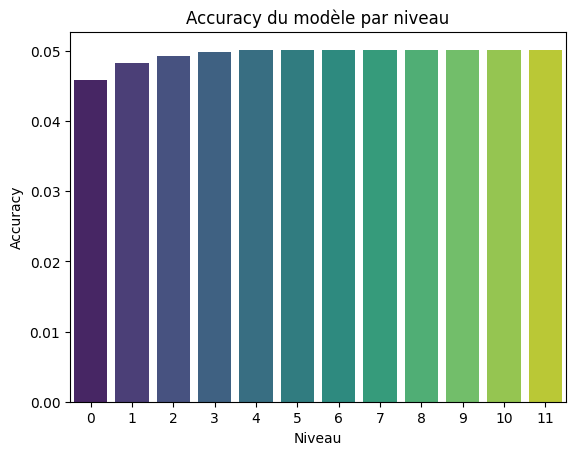

In [59]:
def get_matrix_level(matrix: np.ndarray) -> int:
    """Return the index of the last row with a 1"""
    return next(
        (i - 1 for i in range(matrix.shape[0]) if matrix[i].sum() != 1),
        matrix.shape[0] - 1
    )


level_matrix = {
    level: [] for level in range(MATRIX_SIZE)
}

for i in range(len(test_states)):
    level = get_matrix_level(test_states[i][1])
    level_matrix[level].append(i)

min_level = min(len(level_matrix[level]) for level in level_matrix)
max_level = max(len(level_matrix[level]) for level in level_matrix)

print(
    f"Sample size: [{min_level}, {max_level}]"
)
# show model accuracy for each level
accuracies = []
for level in level_matrix:
    correct = 0
    for i in level_matrix[level][:1000]:
        outputs = model(torch.tensor(
            test_states[i].reshape(1, 2, MATRIX_SIZE, MATRIX_SIZE), dtype=torch.float32).to(device))
        if torch.argmax(outputs).item() == test_values[i]:
            correct += 1
    accuracies.append(correct / len(level_matrix[level]))

fig, ax = plt.subplots()
sns.set_style()
sns.barplot(x=np.array(list(level_matrix.keys())),
            y=np.array(accuracies), ax=ax, palette="viridis")
ax.set_title("Accuracy du modèle par niveau")
ax.set_xlabel("Niveau")
ax.set_ylabel("Accuracy")
plt.show()

## Test du modèle sur des graphes générés aléatoirement

In [60]:
@ray.remote
def generate_graph(size: int) -> nx.Graph:
    graph = nx.fast_gnp_random_graph(size, 0.5)
    while not nx.is_connected(graph):
        graph = nx.fast_gnp_random_graph(size, 0.5)
    # Add random weights to the nodes
    for node in graph.nodes:
        graph.nodes[node]["weight"] = np.random.randint(0, 10)
    return graph


def get_cost_matrix(g1: nx.Graph, g2: nx.Graph) -> np.ndarray:
    """
    Create the cost matrix between the two graphs.

    Args:
        g1 (nx.Graph): The first graph.
        g2 (nx.Graph): The second graph.
        cost (dict): The cost dictionary.

    Returns:
        pd.DataFrame: The cost matrix.
    """
    n = len(g1.nodes)
    m = len(g2.nodes)

    # Create the cost matrix
    degree_cost = np.zeros((n, m))
    for i, node_1 in enumerate(g1.nodes):
        for j, node_2 in enumerate(g2.nodes):
            degree = abs(g1.degree[node_1] - g2.degree[node_2])
            cost_sub = 0 if g1.nodes[node_1]["weight"] == g2.nodes[node_2]["weight"] else 1
            degree_cost[i, j] = cost_sub + degree

    # Create the delete cost matrix
    delete_cost = np.zeros((n, n))
    for i, j in itertools.product(range(n), range(n)):
        node_degree = g1.degree[i]
        delete_cost[i, j] = 1 + node_degree

    # Create the insert cost matrix
    insert_cost = np.zeros((m, m))
    for j in range(m):
        node_degree = g2.degree[j]
        insert_cost[:, j] = 1 + node_degree

    # Create the substitution cost matrix
    sub_cost = np.zeros((m, n))

    # Create the cost matrix
    cost_matrix = np.zeros((n + m, n + m))
    for i, j in itertools.product(range(n + m), range(n + m)):
        if i < n and j < m:
            cost_matrix[i, j] = degree_cost[i, j]
        elif i < n:
            cost_matrix[i, j] = delete_cost[i, j - m]
        elif j < m:
            cost_matrix[i, j] = insert_cost[i - n, j]
        else:
            cost_matrix[i, j] = sub_cost[i - n, j - m]

    return cost_matrix


@ray.remote
def calculate_ged(g1, g2):
    cost_matrix = get_cost_matrix(g1, g2)
    ged = nx.graph_edit_distance(g1, g2)
    return g1, g2, cost_matrix, ged


def generate_data(n: int, size: int, verbose: bool = False) -> pd.DataFrame:
    graphs = ray.get([generate_graph.remote(size) for _ in range(n)])

    combinations = itertools.combinations(graphs, 2)
    if verbose:
        combinations = tqdm.tqdm(combinations, total=n * (n - 1) // 2)
    data = [calculate_ged.remote(g1, g2) for g1, g2 in combinations]
    results = ray.get(data)

    return pd.DataFrame(results, columns=["g1", "g2", "cost_matrix", "ged"])

In [61]:
data_size = 10
n = int((1 + np.sqrt(1 + 8 * data_size)) / 2)
print(f"Generating {n} graphs")

graphs = generate_data(n, MATRIX_SIZE, verbose=True)
print(f"Taille du dataset : {len(graphs)}")
ray.shutdown()

Generating 5 graphs


2024-03-22 08:29:57,582	INFO worker.py:1673 -- Started a local Ray instance.
100%|██████████| 10/10 [00:00<00:00, 900.01it/s]


KeyboardInterrupt: 